# DS in LS Week 5
## SEIRD Model for modelling COVID-19

In [1]:
# Imports
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import pandas as pd
import datetime

## 3. Fit the model to real-world data, either Germany or Berlin.

### Fitting real data

Load in the data from the RKI npgeo dataset

In [2]:
# dataset:
# https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0
# Metadata: https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
rki_covid_data = pd.read_csv("RKI_COVID19.csv", header=0, sep=",")
rki_covid_data.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,8389847,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
1,8389848,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
2,8389849,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
3,8389850,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
4,8389851,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt


In [3]:
# create a column containing the date
rki_covid_data["Date"] = pd.to_datetime(rki_covid_data['Meldedatum'], format='%Y/%m/%d %H:%M:%S.%f')
rki_covid_data["Date"] = rki_covid_data['Date'].dt.date
rki_covid_data.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,Date
0,8389847,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-14
1,8389848,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-19
2,8389849,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-19
3,8389850,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-21
4,8389851,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt,2020-03-27


In [4]:
# filter the dataframe for infected cases per day by multiplying entries by the number of infected cases they count
infected_per_day = rki_covid_data.groupby("Date")['AnzahlFall'].sum()
'''
infected_per_day = pd.DataFrame(index=infected_per_day_pre.index.get_level_values('Date'))
infected_per_day["infecteds"] = 0
for date in infected_per_day.index:
    for level in infected_per_day_pre.loc[date].index.get_level_values(0):
        infected_per_day.at[date, "infecteds"] = infected_per_day.at[date, "infecteds"] + level * infected_per_day_pre.loc[date, level]
infected_per_day
'''

'\ninfected_per_day = pd.DataFrame(index=infected_per_day_pre.index.get_level_values(\'Date\'))\ninfected_per_day["infecteds"] = 0\nfor date in infected_per_day.index:\n    for level in infected_per_day_pre.loc[date].index.get_level_values(0):\n        infected_per_day.at[date, "infecteds"] = infected_per_day.at[date, "infecteds"] + level * infected_per_day_pre.loc[date, level]\ninfected_per_day\n'

In [156]:
infected_per_day[:3]

Date
2020-01-28    4
2020-01-29    2
2020-01-31    3
Name: AnzahlFall, dtype: int64

In [50]:
# infected before 2020/3/1
infected_before = infected_per_day[:datetime.date(2020,2,29)].sum()
infected_before

127

In [7]:
# drop all dates before 2020/3/1
data_pre = infected_per_day[datetime.date(2020,3,1):]
data_pre.head()

Date
2020-03-01     38
2020-03-02     41
2020-03-03     83
2020-03-04    158
2020-03-05    190
Name: AnzahlFall, dtype: int64

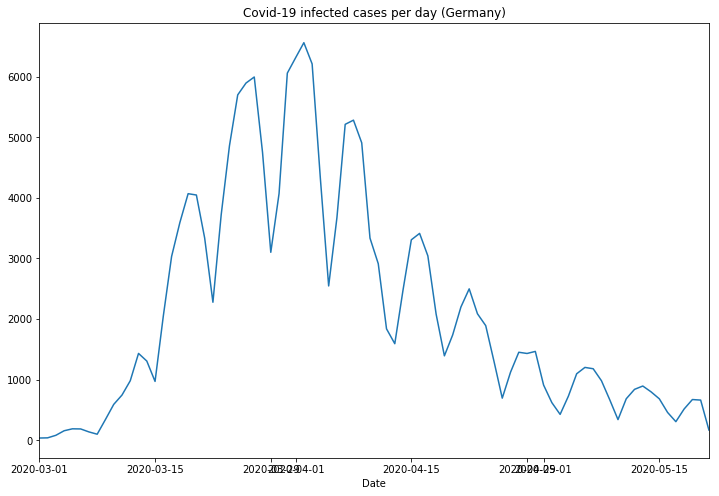

In [8]:
data_pre.plot(figsize=(12, 8), title="Covid-19 infected cases per day (Germany)")

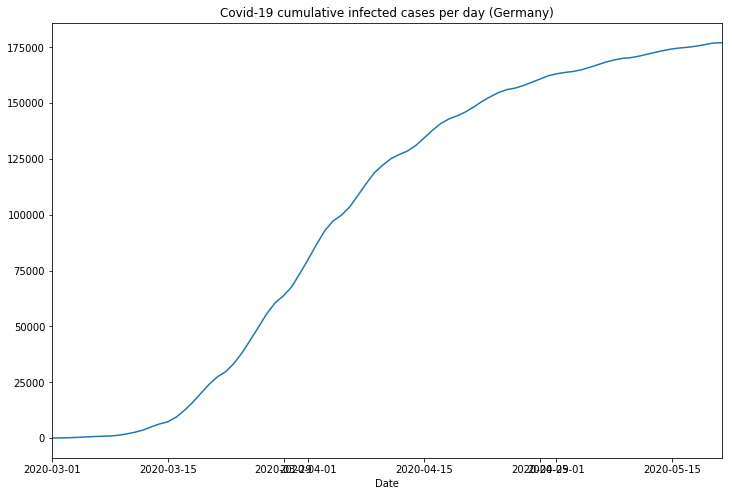

In [9]:
data_pre.cumsum().plot(figsize=(12, 8), title="Covid-19 cumulative infected cases per day (Germany)")

In [10]:
rki_covid_data["Altersgruppe"].unique()

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A05-A14', 'A00-A04',
       'unbekannt'], dtype=object)

In [11]:
# calculate the deaths per agegroup
deaths_per_agegroup = [0, 0, 0, 0, 0]
for i in range(-1, rki_covid_data["AnzahlTodesfall"].max()+1):
    deaths_per_agegroup[0] = deaths_per_agegroup[0] + i * len(rki_covid_data[((rki_covid_data["Altersgruppe"] == "A00-A04") |  (rki_covid_data["Altersgruppe"] == "A05-A14")) & (rki_covid_data["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[1] = deaths_per_agegroup[1] + i * len(rki_covid_data[(rki_covid_data["Altersgruppe"] == "A15-A34") & (rki_covid_data["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[2] = deaths_per_agegroup[2] + i * len(rki_covid_data[(rki_covid_data["Altersgruppe"] == "A35-A59") & (rki_covid_data["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[3] = deaths_per_agegroup[3] + i * len(rki_covid_data[(rki_covid_data["Altersgruppe"] == "A60-A79") & (rki_covid_data["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[4] = deaths_per_agegroup[4] + i * len(rki_covid_data[(rki_covid_data["Altersgruppe"] == "A80+") & (rki_covid_data["AnzahlTodesfall"] == i)])
deaths_per_agegroup

[1, 16, 351, 2595, 5210]

In [12]:
data = data_pre.cumsum().values
data 

array([    38,     79,    162,    320,    510,    698,    837,    938,
         1282,   1875,   2622,   3605,   5039,   6347,   7319,   9371,
        12404,  15996,  20065,  24112,  27450,  29728,  33449,  38308,
        44007,  49901,  55895,  60646,  63748,  67819,  73877,  80188,
        86748,  92958,  97273,  99820, 103493, 108706, 113988, 118896,
       122232, 125146, 126985, 128579, 131062, 134370, 137784, 140827,
       142909, 144303, 146041, 148241, 150740, 152828, 154720, 156023,
       156719, 157843, 159296, 160729, 162196, 163108, 163730, 164158,
       164887, 165985, 167188, 168369, 169352, 170022, 170364, 171050,
       171891, 172787, 173587, 174272, 174732, 175040, 175557, 176230,
       176894, 177064], dtype=int64)

In [32]:
# parameters
# set the total population number
# from here: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/zensus-geschlecht-staatsangehoerigkeit-2019.html;jsessionid=B6506D714A8218B0616748EA21EBBFB1.internet8721
N = 83149300
# use the culumlative death counts as data input
data = data_pre.cumsum().values
outbreak_shift = 30
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    data = np.concatenate((np.zeros(outbreak_shift), data))
# for the agegroups take demographics percentages from 2018 data and apply to N
# from here: https://de.statista.com/statistik/daten/studie/1351/umfrage/altersstruktur-der-bevoelkerung-deutschlands/
# 0-14, 14-34, 35-59, 60-79, 80+
total_2018 = 83019000.0
age_percentages_2018 = [11290815/total_2018, 19213113/total_2018, 29137839/total_2018, 
                        17988340/total_2018, 5389106/total_2018]
agegroups = [N * x for x in age_percentages_2018] 
total_deaths = sum(deaths_per_agegroup)
alpha_by_agegroup = {"0-14": deaths_per_agegroup[0]/total_deaths, "15-34": deaths_per_agegroup[1]/total_deaths, 
                     "35-59": deaths_per_agegroup[2]/total_deaths, "60-79": deaths_per_agegroup[3]/total_deaths, "80+": deaths_per_agegroup[4]/total_deaths}
proportion_of_agegroup = {"0-14": age_percentages_2018[0], "15-34": age_percentages_2018[1], 
                          "35-59": age_percentages_2018[2], "60-79": age_percentages_2018[3], "80+": age_percentages_2018[4]}

# for the prevoius conditions take the death rate by previous condition 
# from here: https://de.statista.com/statistik/daten/studie/1102109/umfrage/mortalitaetsrate-des-coronavirus-nach-vorerkrankung/
alpha_by_condition = {"nothing": 0.0, "other": 0.08, "pulmonary": 0.13}
proportion_of_condition = {"nothing": 0.3, "other": 0.6, "pulmonary": 0.1}

# from here: https://www.tagesspiegel.de/wissen/grosse-datenanalyse-zu-krankenhaeusern-hier-koennten-die-intensivbetten-in-deutschland-knapp-werden/25746240.html
total_beds = 33500
beds_per_100k = total_beds * 100000 / N

# add a factor to the deathrate depending on demographics and previous conditions
alpha_opt_1 = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))
alpha_opt_2 = sum(alpha_by_condition[i] * proportion_of_condition[i] for i in list(alpha_by_condition.keys()))

# set parameters for fitting, form: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), 
                       "alpha_start": (0.4, 0.01, 0.7), "alpha_change": (-0.005, -0.0001, -0.01), #"k2": (2.5, 0.01, 5.0), "x2_0": (75, 0, 120), "a_0_end": (0.2, 0.01, 0.8),
                      "s": (0.003, 0.001, 0.01), "s1": (0.3, 0.0, 0.5), "s2": (0.3, 0.0, 0.5)} 

In [33]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, alpha_t, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * alpha_t(t) * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - alpha_t(t)) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - alpha_t(t)) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * alpha_t(t) * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [55]:
gamma = 1.0/9.0 # the proportion of infected recovering per day
sigma = 1.0/3.0 # 1 devided by the incubation period in days

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, infected_before, beds_per_100k, R_0_start, k, x0, R_0_end, alpha_start, alpha_change, prob_I_to_C, s, s1, s2):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    
    # the death rate as a time dependent function, with factor age, previous conditions and decline over time through better treatment availability
#     def alpha_t(t):
#         return (a_0_start-a_0_end) / (1 + np.exp(-k2*(-t+x2_0))) + a_0_end + s1 * alpha_opt_1 + s2 * alpha_opt_2
    def alpha_t(t):
        return (max(0.0, (alpha_start + t * alpha_change + s1 * alpha_opt_1 + s2 * alpha_opt_2) ))

    y0 = N-infected_before, infected_before, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, alpha_t, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    alpha_t_over_time = [alpha_t(i) for i in t]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time

In [56]:
def fitter(x, R_0_start, k, x0, R_0_end, alpha_start, alpha_change, prob_I_to_C, s, s1, s2):
    ret = Model(days, agegroups, infected_before, beds_per_100k, R_0_start, k, x0, R_0_end, alpha_start, alpha_change, prob_I_to_C, s, s1, s2)
    return ret[6][x]

In [57]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [58]:
x_data = np.linspace(0, days - 1, days, dtype=int)
result = mod.fit(data, params, method="least_squares", x=x_data)

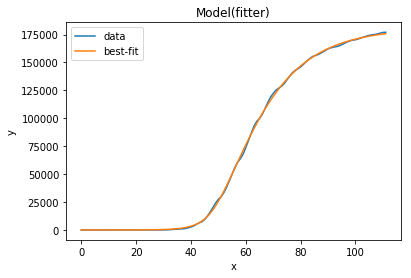

In [59]:
result.plot_fit(datafmt="-");

In [60]:
result.best_values

{'R_0_start': 4.879985496353624,
 'k': 0.7702920713311963,
 'x0': 44.93671952012496,
 'R_0_end': 0.34274480879185326,
 'alpha_start': 0.6953713374554839,
 'alpha_change': -0.00046081271053732527,
 'prob_I_to_C': 0.09990123354034777,
 's': 0.009955000000000047,
 's1': 0.49945040288780396,
 's2': 0.4962388163653382}

In [136]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU, from: {S_2[0] * 100}, to:{S_2[-1] * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
#         ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
#         ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')



    ax.title.set_text('extended SEIR-Model zoomed')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    print("final numbers: S: {:.0f} E: {:.0f} I: {:.0f} C: {:.0f} R: {:.0f} D: {:.0f}".format(S[-1],E[-1],I[-1],C[-1],R[-1],D[-1]))
    
    f = plt.figure(figsize=(20,8))
    # sp1
    ax1 = f.add_subplot(221)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
    # sp2
    ax4 = f.add_subplot(222)
    if x_ticks is None:
        ax4.plot(t, S_2, 'b--', alpha=0.7, linewidth=2, label='alpha_t')
    else:
        ax4.plot(x_ticks, S_2, 'b--', alpha=0.7, linewidth=2, label='alpha_t')

 
    ax4.title.set_text('alpha_t over time')
    ax4.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax4.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp3
    ax2 = f.add_subplot(223)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp4
    ax3 = f.add_subplot(224)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

Prediction for Germany
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:69.6731264907109


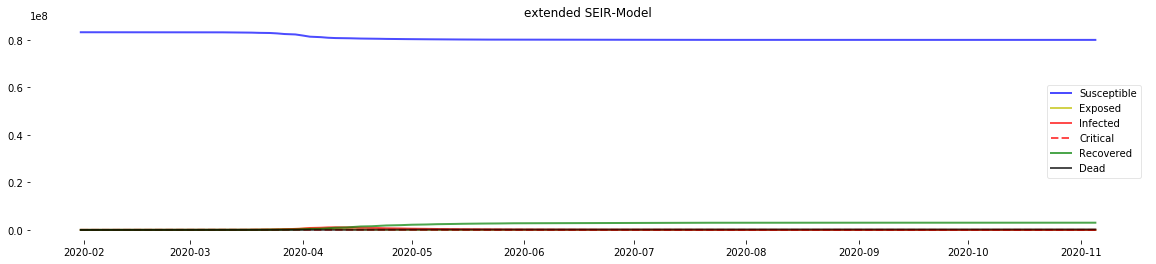

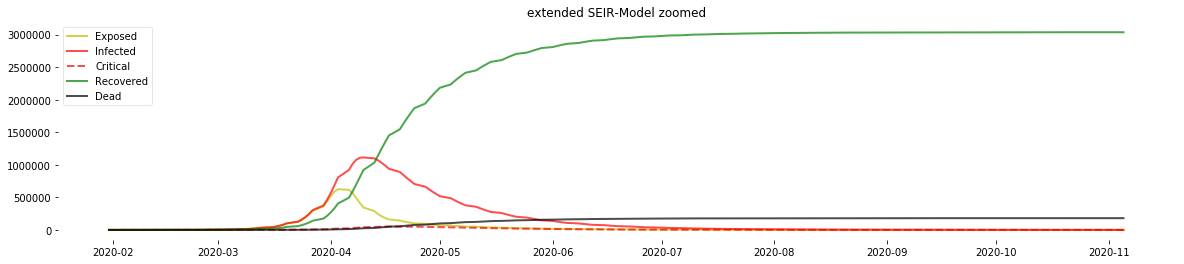

final numbers: S: 79932186 E: 15 I: 110 C: 12 R: 3036411 D: 180567


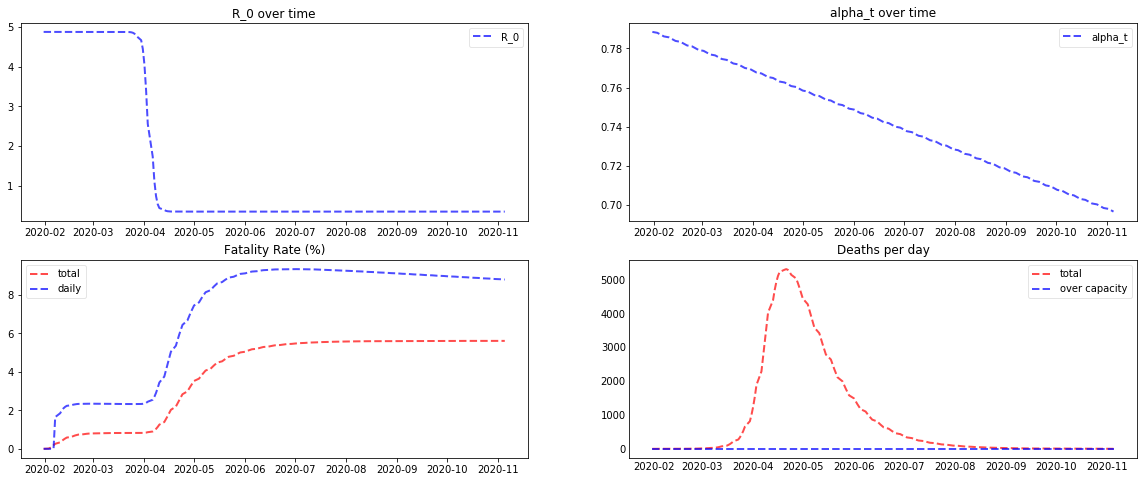

In [144]:
full_days = 200 
first_date = data_pre.index[0]- datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="C")
print("Prediction for Germany")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k, **result.best_values), x_ticks=x_ticks);

## 4. Simulate different situations: lock-down, people are reducing social contacts a lot, people are reducing social contacts moderately, people are reducing social contacts moderately and are wearing masks.

### 4.1 lock-down

Prediction lock-down on day 120
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:69.6731264907109


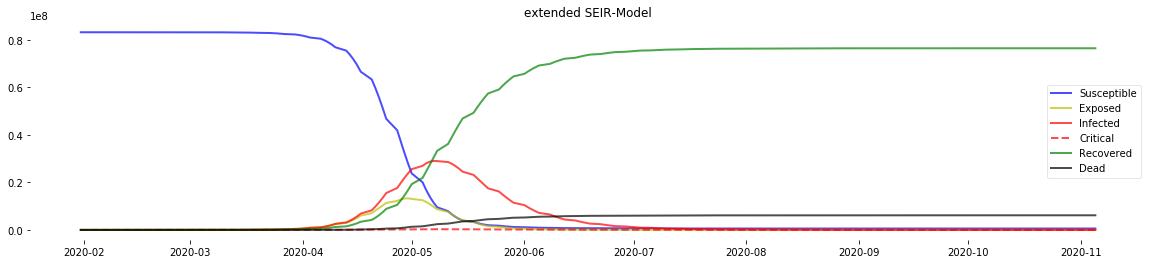

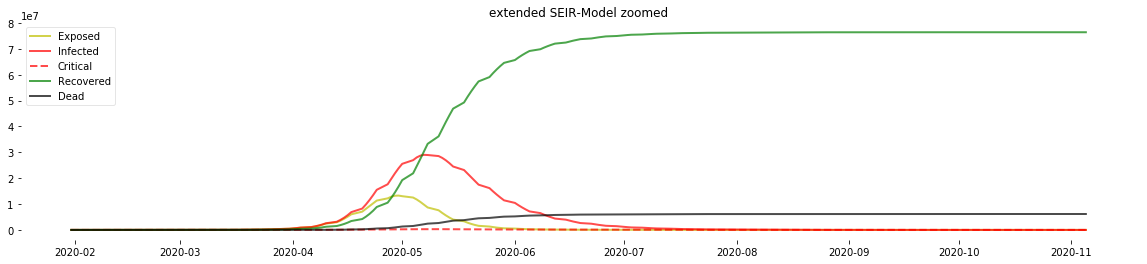

final numbers: S: 589413 E: 0 I: 70 C: 18 R: 76407102 D: 6152697


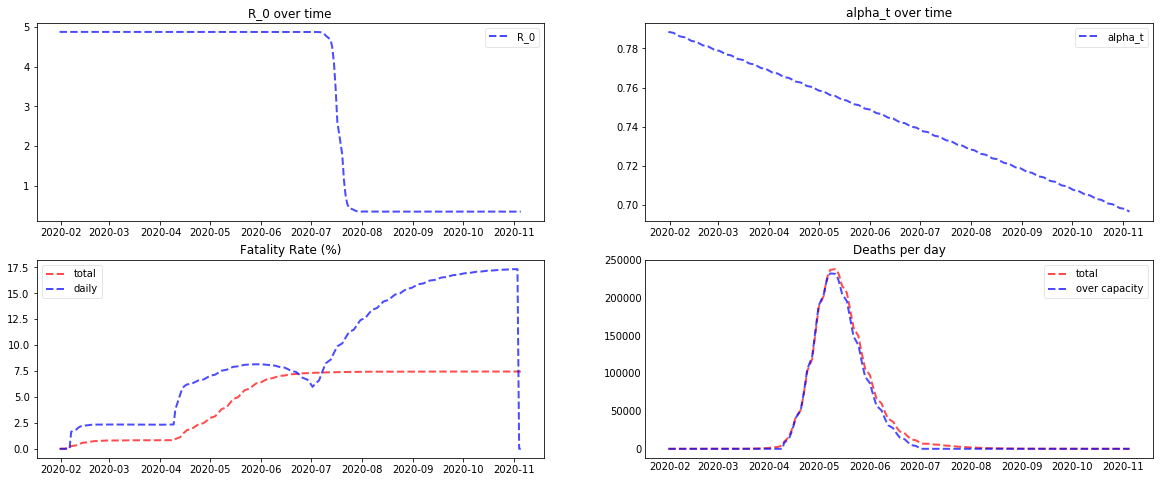

In [145]:
# lockdown only on day 120 onstead of day 63
full_days = 200
first_date = data_pre.index[0] - datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="C")
input_vals = list(result.best_values.values())
input_vals[2] = 120 #replace the value of x0
print("Prediction lock-down on day 120")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k, *input_vals), x_ticks=x_ticks);

Prediction lock-down on day 20
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:69.6731264907109


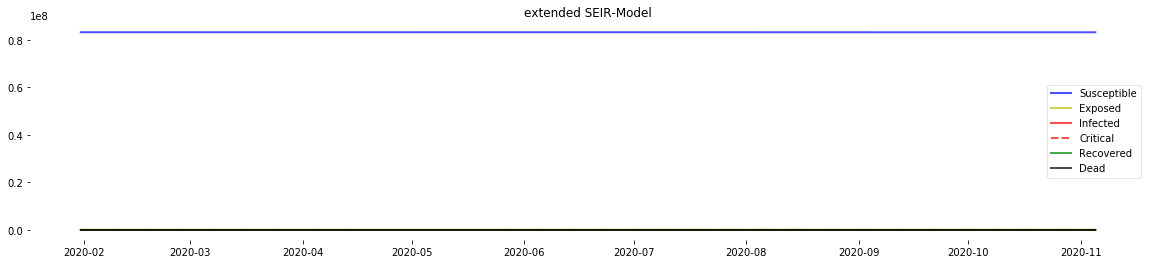

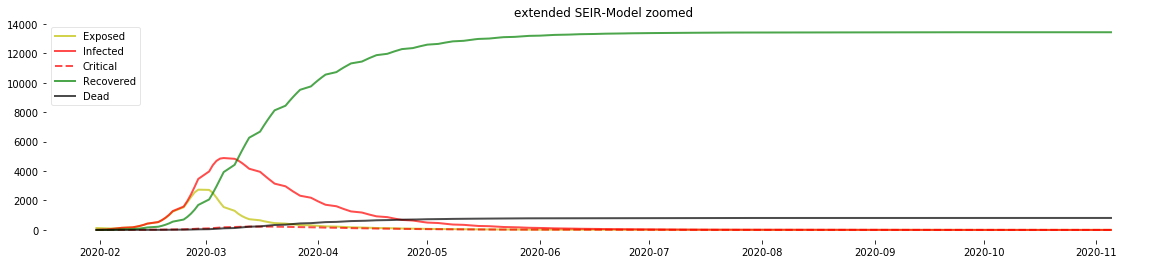

final numbers: S: 83135062 E: 0 I: 0 C: 0 R: 13426 D: 812


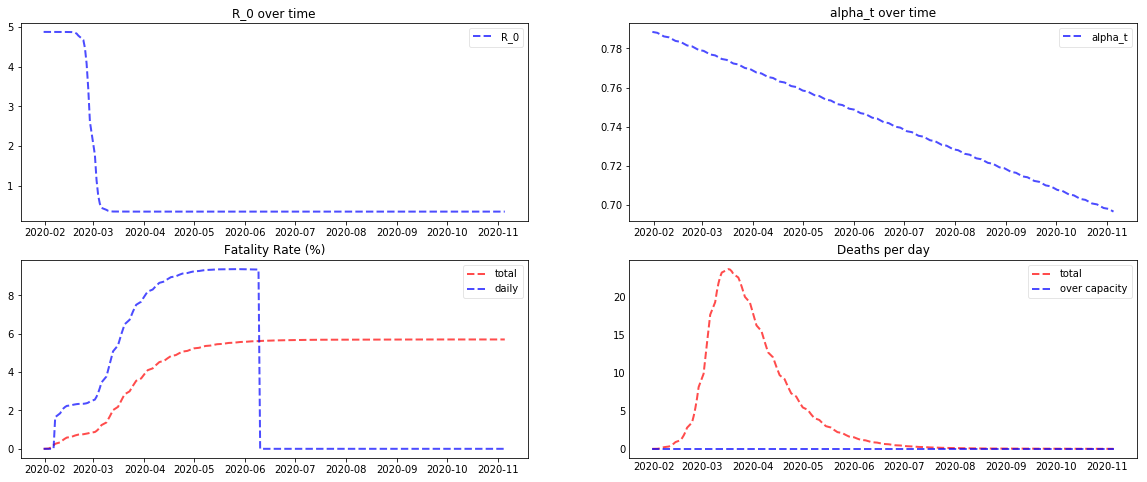

In [146]:
# lockdown on day 20 onstead of day 63
full_days = 200
first_date = data_pre.index[0]- datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="C")
input_vals = list(result.best_values.values())
input_vals[2] = 20 #replace the value of x0
print("Prediction lock-down on day 20")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.2 people are reducing social contacts a lot

Prediction R_0_end of 0.1
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:69.6731264907109


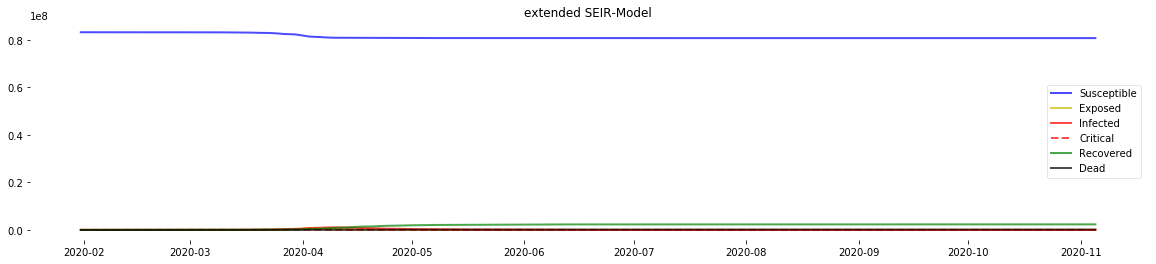

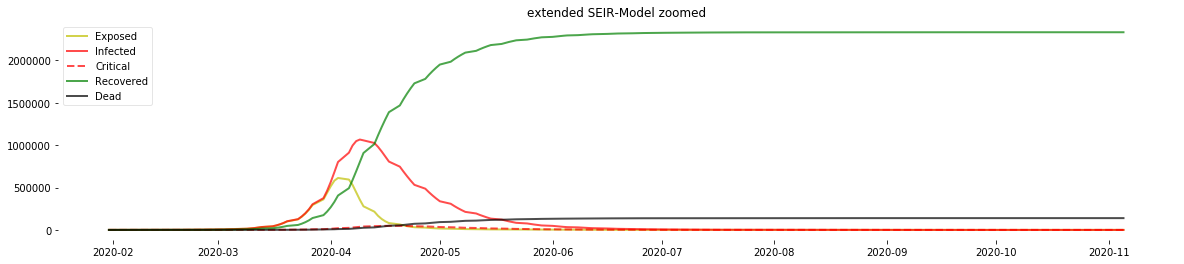

final numbers: S: 80677340 E: 0 I: 1 C: 0 R: 2332741 D: 139217


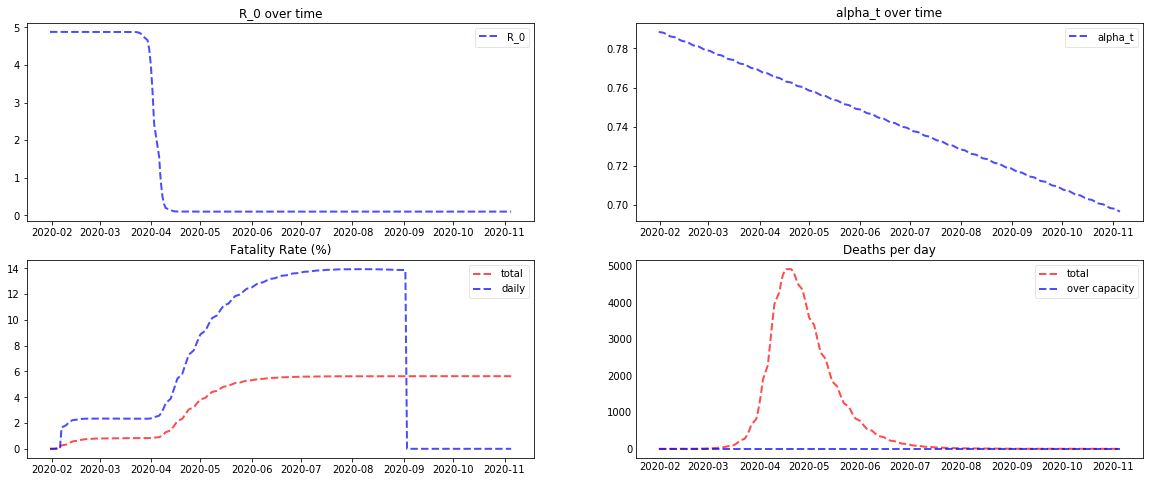

In [148]:
# an infected person can in the end only infect 0.5 other people
full_days = 200
first_date = data_pre.index[0]- datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="C")
input_vals = list(result.best_values.values())
input_vals[3] = 0.1 #replace the value of R_0_end
print("Prediction R_0_end of 0.1")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.3 people are reducing social contacts moderately

Prediction R_0_end of 2
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:69.6731264907109


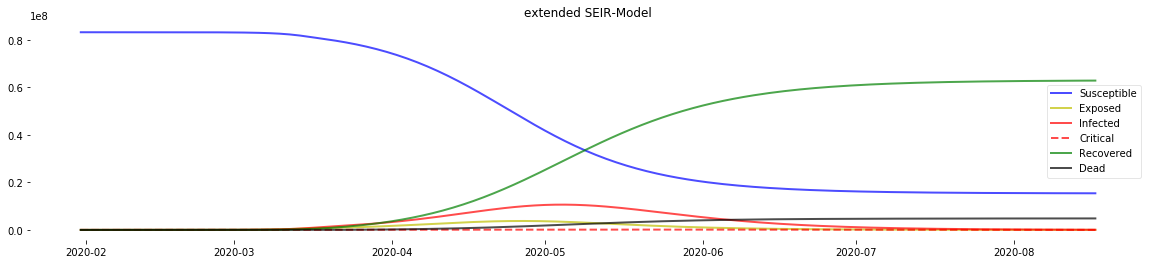

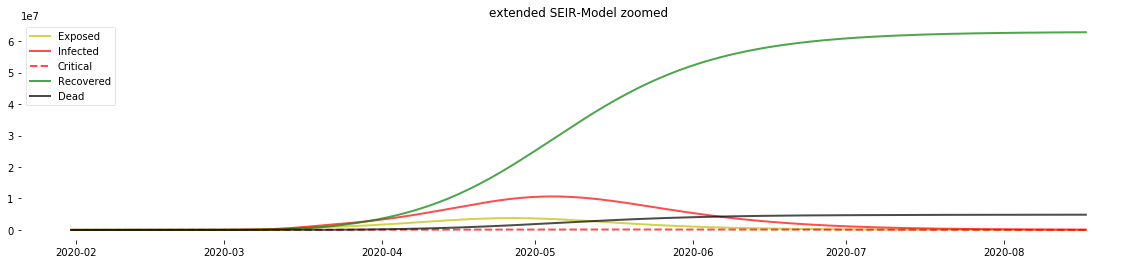

final numbers: S: 15405587 E: 11519 I: 76866 C: 7816 R: 62812847 D: 4834665


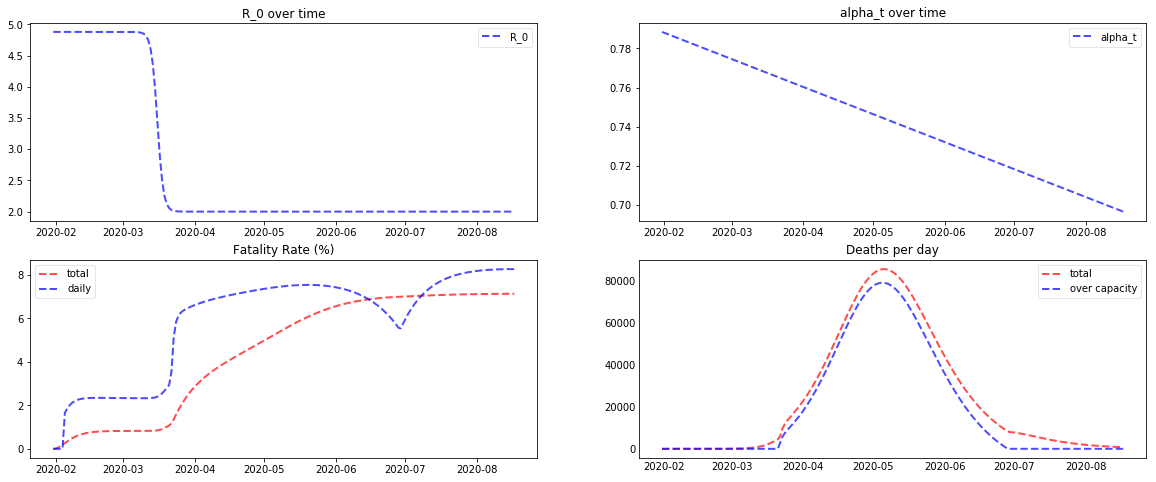

In [150]:
# an infected person can in the end only infect 2 other people
full_days = 200
first_date = data_pre.index[0] - datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
input_vals[3] = 2 #replace the value of R_0_end
print("Prediction R_0_end of 2")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.4 people are reducing social contacts moderately and are wearing masks

Prediction R_0_end of 1
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:69.6731264907109


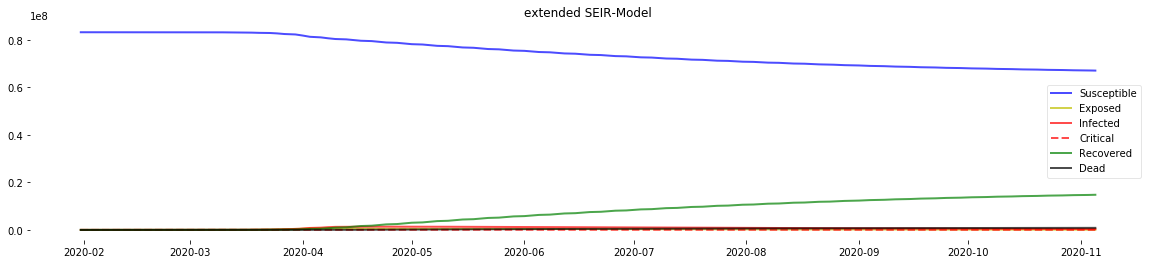

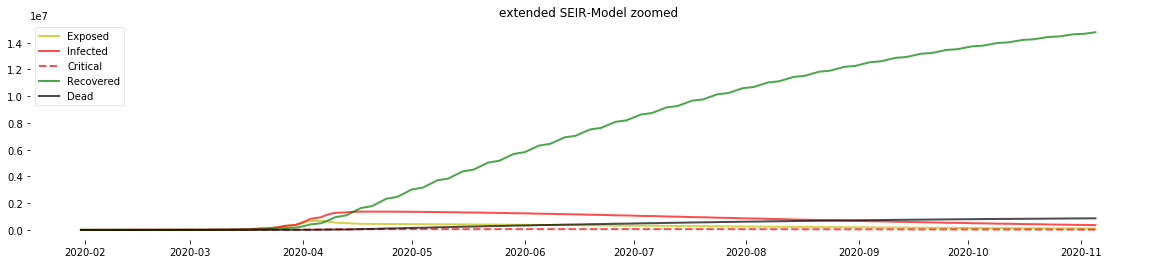

final numbers: S: 67017610 E: 100759 I: 358210 C: 23814 R: 14781768 D: 867139


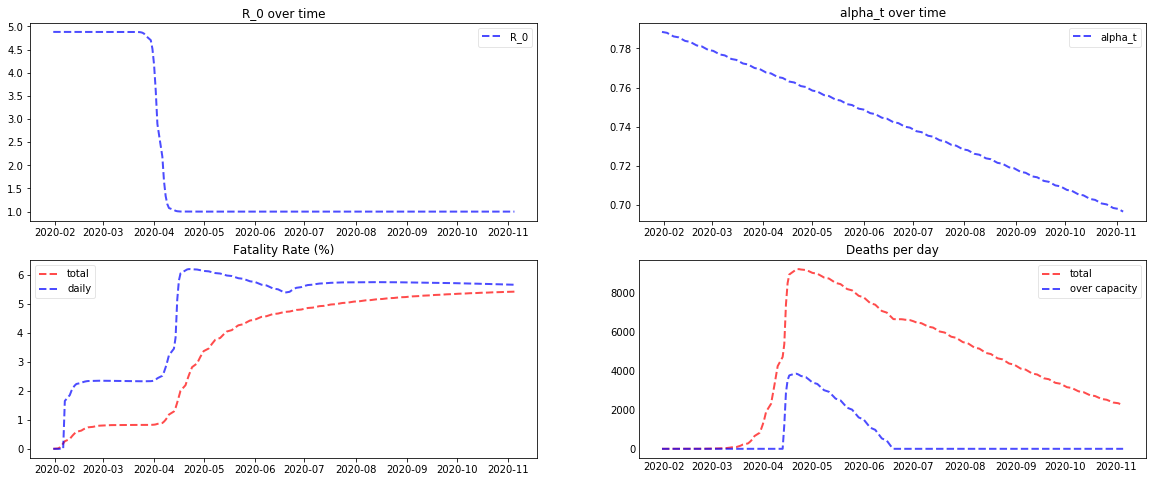

In [153]:
# an infected person can in the end only infect 1 other person
full_days = 200 
first_date = data_pre.index[0] - datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="C")
input_vals = list(result.best_values.values())
input_vals[3] = 1 #replace the value of R_0_end
print("Prediction R_0_end of 1")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.5 a treatment is discovered and reduces the death rate quickly

Prediction alpha_change of -0.01
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:0.0


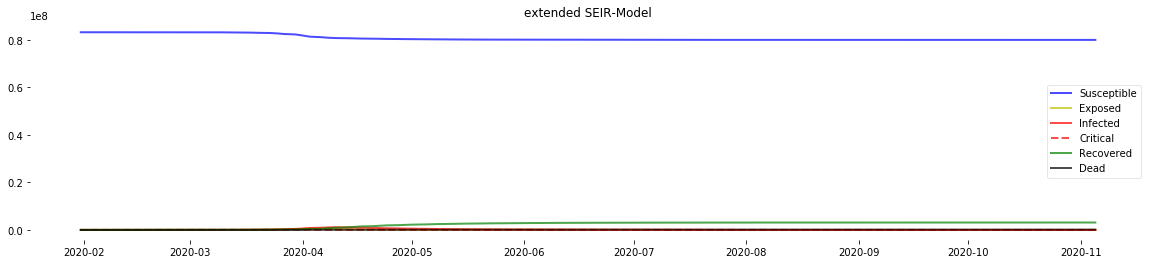

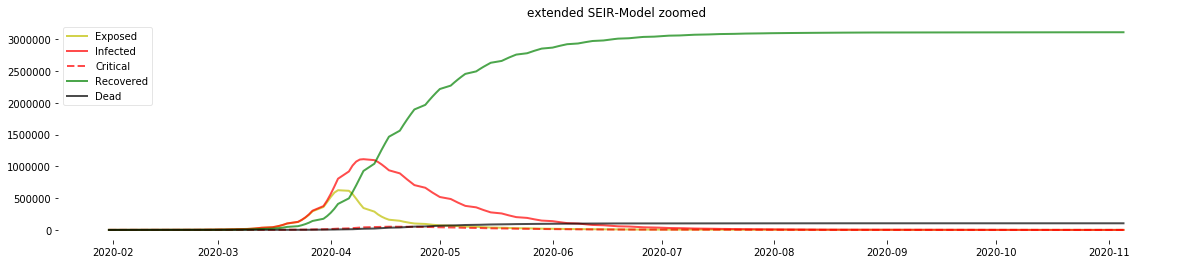

final numbers: S: 79932185 E: 15 I: 110 C: 10 R: 3112613 D: 104367


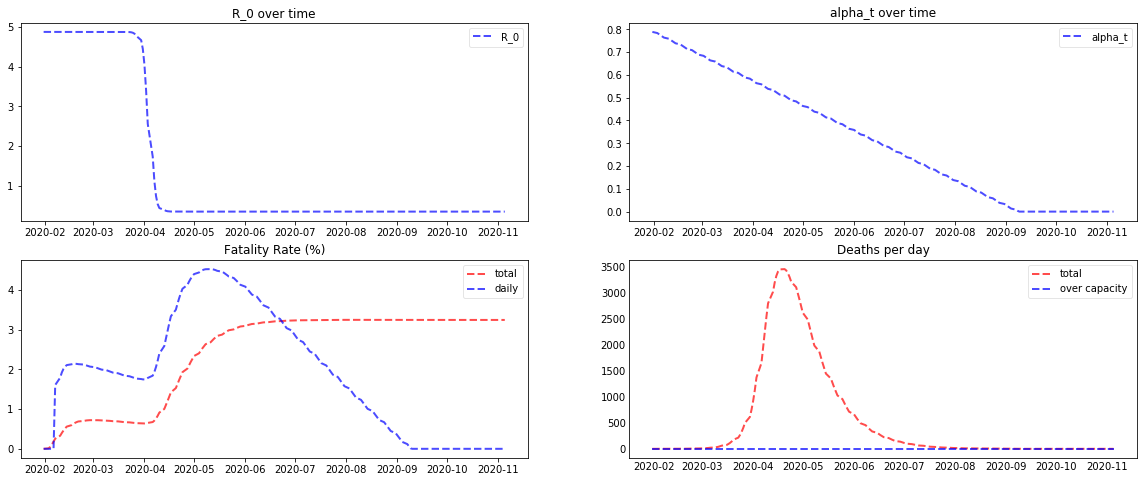

In [154]:
# deathrate drops much faster from -0.001 to -0.005 per day
full_days = 200 
first_date = data_pre.index[0]- datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="C")
input_vals = list(result.best_values.values())
input_vals[5] = -0.005 #replace the value of alpha_change
print("Prediction alpha_change of -0.01")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.6 less ICU beds are available

Prediction beds_per_100k // 4
percentage going to ICU: 9.990123354034777; percentage dying in ICU, from: 78.84329943040368, to:69.6731264907109


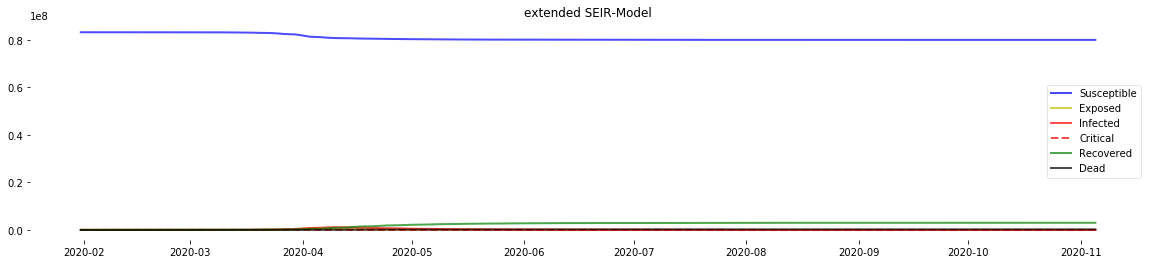

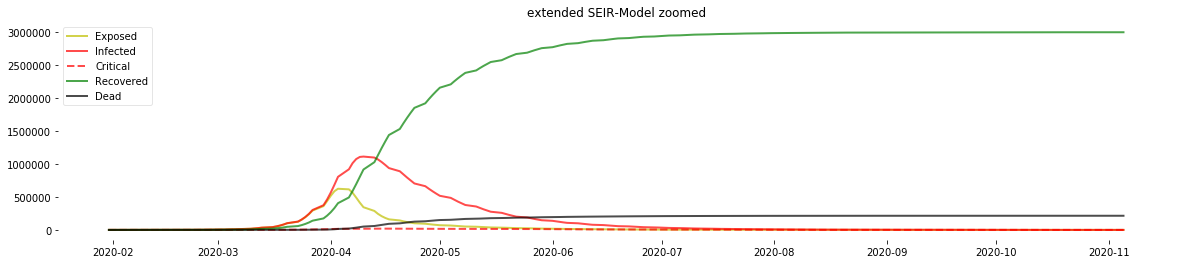

final numbers: S: 79932186 E: 15 I: 110 C: 12 R: 3001877 D: 215100


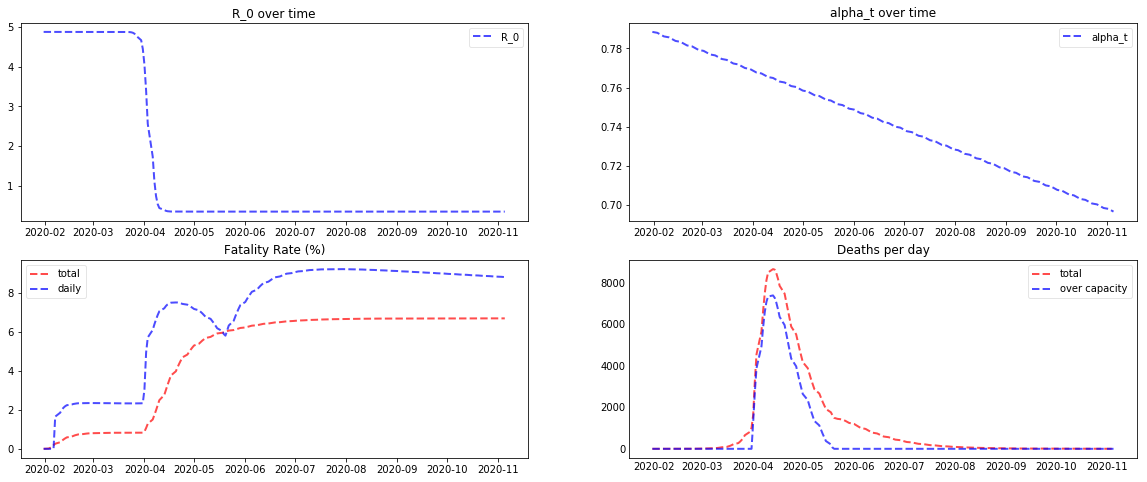

In [155]:
# only a quarter of the number of icu beds are available
full_days = 200 
first_date = data_pre.index[0]- datetime.timedelta(days=outbreak_shift)
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="C")
input_vals = list(result.best_values.values())
print("Prediction beds_per_100k // 4")
plotter(*Model(full_days, agegroups, infected_before, beds_per_100k // 4, *input_vals), x_ticks=x_ticks);